In [1]:
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
SIZES = ['14m', '70m', '160m', '2.8b', '12b']
CKPTS = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 
         1000, 2000, 3000, 4000, 8000, 13000, 23000 ,32000, 33000, 43000,
         53000, 63000, 64000, 73000, 83000, 93000, 103000, 113000, 123000, 133000,
         143000]
SCALING_SIZES = ['410m', '1.4b', '6.9b']
DATASETS = [1, 2, 3, 4]
DATASET_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


HIDDEN_DIMS = {
    '14m': 128, 
    '70m': 512, 
    '160m': 768, 
    '410m': 1024,
    '1.4b': 2048,
    # '2.8b': 2560, 
    '6.9b': 4096,
    '12b': 5120,
}

MODES = ['sane', 'shuffled']

In [3]:
results_df = pd.read_csv('results/emily_id_results_all.csv')

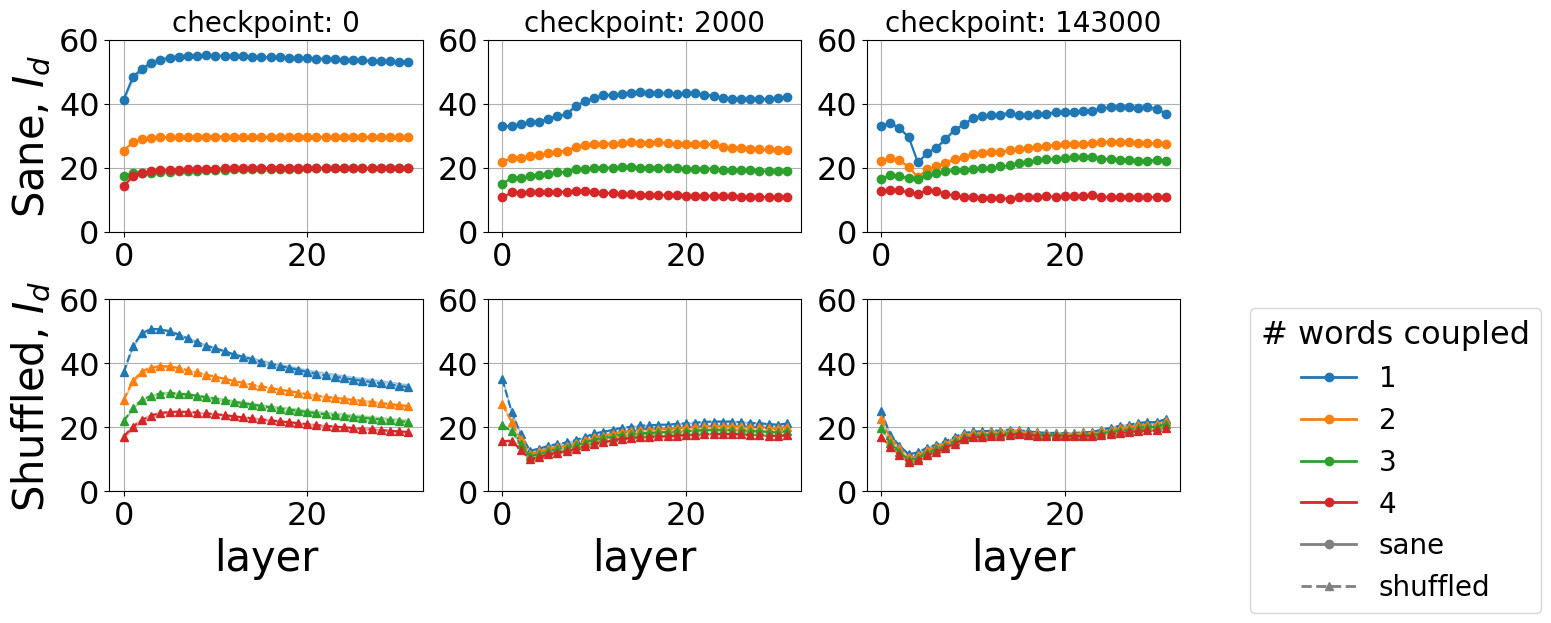

In [16]:
ckpts = [0, 2000, 143000]
model = '6.9b'
fig, axs = plt.subplots(2, len(ckpts), figsize=(4 * len(ckpts), 6))
method = 'twonn'
for i, mode in enumerate(['sane', 'shuffled']):
    for j, ckpt in enumerate(ckpts):
        # plot over layers
        ax = axs[i][j]
        # first get the x and y and std for sane
        model_df = results_df[(results_df['model']==model) & (results_df['step']==ckpt)]

        setting_df = model_df[model_df['mode'] == mode]

        for ds in DATASETS:
            df = setting_df[setting_df['words_coupled']==ds]
            if method == 'twonn':
                ax.set_ylim(0,60)
            if method == 'pca':
                ax.set_ylim(0,3000)
            #ax.set_yscale('log')
            ax.plot(
                df['layer'], 
                df[f'{method}_mean'], 
                color=DATASET_COLORS[ds-1], 
                marker='o' if mode == 'sane' else '^',
                linestyle='--' if mode == 'shuffled' else None,
                markersize=6
            )
            ax.fill_between(df['layer'], 
                df[f'{method}_mean'] - df[f'{method}_std'],
                df[f'{method}_mean'] + df[f'{method}_std'],
                alpha=0.3,
                color=DATASET_COLORS[ds-1]
                               )
     
        if i == 0:
            ax.set_title(f'checkpoint: {ckpt}', fontsize=20)
        ax.grid(True)
        # ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
        ax.tick_params(axis='x', labelsize=23)
        ax.tick_params(axis='y', labelsize=23)
        if i == 1: 
            ax.set_xlabel('layer', fontsize=30)
        if method == 'twonn':
            if j == 0:
                if i == 0:
                    ax.set_ylabel(r'Sane, $I_d$', fontsize=30)
                else:
                    ax.set_ylabel(r'Shuffled, $I_d$', fontsize=30)
        if method == 'pca':
            if j == 0:
                if i == 0:
                    ax.set_ylabel(r'Sane, $d$', fontsize=30)
                else:
                    ax.set_ylabel(r'Shuffled, $d$', fontsize=30)
    

# Custom legend handles for both subplots

custom_lines = [Line2D([0], [0], color=color, marker='o', lw=2) for color in DATASET_COLORS] + \
    [Line2D([0], [0], color='gray', lw=2, marker = 'o'), Line2D([0], [0], color='gray', linestyle='--', lw=2, marker = '^')]

fig.legend(custom_lines, 
           [1, 2, 3, 4, 'sane', 'shuffled'], 
           ncol=1, title='# words coupled', bbox_to_anchor=(1.3, 0.5), fontsize=20, title_fontsize=23)
fig.tight_layout()

#for ext in ['svg', 'png', 'pdf']:
#    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/nonlinear_linear_id_app.{ext}', bbox_inches='tight')

In [28]:
results_df['pca_mean']

0          53.4
1          48.8
2          15.8
3          58.6
4          85.6
          ...  
20043    2787.6
20044    2779.4
20045    2758.6
20046    2683.2
20047    2376.8
Name: pca_mean, Length: 20048, dtype: float64

6.9b
1.4b
410m
6.9b
1.4b
410m


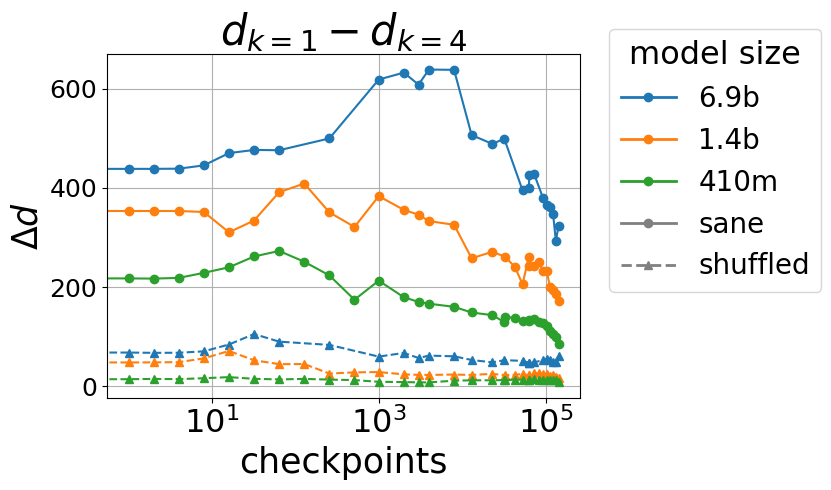

In [22]:
models = ['6.9b', '1.4b', '410m']
fig, ax = plt.subplots(1,1, figsize=(6,5))
diff_list = np.empty((2,len(models), len(CKPTS)))
method ='pca'
for k, mode in enumerate(['sane', 'shuffled']):
    for i,model in enumerate(models):
        print(model)
        last_layer = max(results_df['layer'][results_df['model'] == model])
        cond = (results_df['model'] == model) & (results_df['layer'] == last_layer) & (results_df['mode'] == mode)
        for j,ckpt in enumerate(CKPTS):
            
            id_k1=results_df[cond & (results_df['words_coupled'] == 1) & (results_df['step']==ckpt)][f'{method}_mean']
            id_k4=results_df[cond & (results_df['words_coupled'] == 4) & (results_df['step']==ckpt)][f'{method}_mean']
            if len(id_k1) !=1 or len(id_k4) != 1:
                diff = np.nan
            else:
                diff = id_k1.item()-id_k4.item()
            
            diff_list[k,i, j] = diff


for m in range(2):
    for s in range(len(models)):
        ax.plot(
                np.array(CKPTS)[~np.isnan(diff_list[m,s])],
                diff_list[m,s][~np.isnan(diff_list[m,s])], 
                color=f'C{s}', 
                marker='o' if m == 0 else '^',
                linestyle='--' if m == 1 else None,
                markersize=6,
            )
        #ax.set_yscale('log')
ax.set_xscale('log')

ax.tick_params(axis='x', labelsize=23)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('checkpoints', fontsize=25)
if method == 'twonn':
    ax.set_ylabel(r'$\Delta I_d$', fontsize=25)
    ax.set_title(r'$I_{d,k=1} - I_{d,k=4}$', fontsize=30)
if method == 'pca':
    ax.set_ylabel(r'$\Delta d$', fontsize=25)
    ax.set_title(r'$d_{k=1} - d_{k=4}$', fontsize=30)
ax.grid(True)
custom_lines = [Line2D([0], [0], color=f'C{i}', marker='o', lw=2) for i in range(len(models))] + \
    [Line2D([0], [0], color='gray', lw=2, marker = 'o'), Line2D([0], [0], color='gray', linestyle='--', lw=2, marker = '^')]

fig.legend(custom_lines, 
           models+['sane', 'shuffled'], 
           ncol=1, title='model size', bbox_to_anchor=(1.4, 0.96), fontsize=20, title_fontsize=23)
fig.tight_layout()
    

In [27]:
## Look at the pre-training corpus ID

import json
pythia =json.load(open('results/pythia_checkpoints_twonn_pile_for_jin.json', 'r'))

pythia_step512
pythia-6.9b-deduped_step1000
pythia-6.9b-deduped_step2000
pythia-6.9b-deduped_step3000
pythia_step4000
pythia-6.9b-deduped_step8000
pythia_step16000
pythia-6.9b-deduped_step32000
pythia_step64000
pythia_step143000


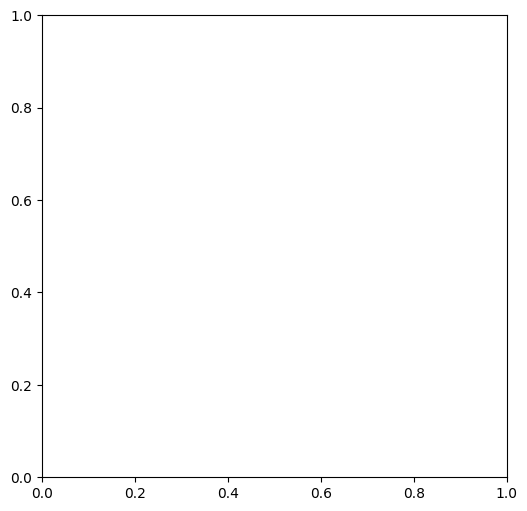

In [34]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ckpts = []
ids = []
for k,v, in pythia.items():
    ckpt = int(k.split('step')[-1])
    ckpts.append(ckpt)
    ids.append(v['id'][-1])

/tmp/ipykernel_2281657/501887762.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0','16','31'])


"\nfor i in range(len(layers)):\n    ax.scatter(steps[~np.isnan(pca_mean_list[i])], pca_mean_list[i,~np.isnan(pca_mean_list[i])], marker = 'o', color=colormap(normalize(i)))\n    ax.fill_between(steps[~np.isnan(pca_mean_list[i])], \n                pca_mean_list[i,~np.isnan(pca_mean_list[i])] - pca_std_list[i,~np.isnan(pca_std_list[i])],\n                pca_mean_list[i,~np.isnan(pca_mean_list[i])] + pca_std_list[i,~np.isnan(pca_std_list[i])],\n                alpha=0.3,\n                 color=colormap(normalize(i)))\nax.set_xscale('log')\nax.set_xlabel('checkpoints', fontsize= 18)\nax.set_ylabel(r'$d$', fontsize = 18)\nax.tick_params(axis='x', labelsize=18)\nax.tick_params(axis='y', labelsize=18)\nplt.legend(title = 'layer', bbox_to_anchor = [1,0.8], fontsize=13, title_fontsize=13)\n"

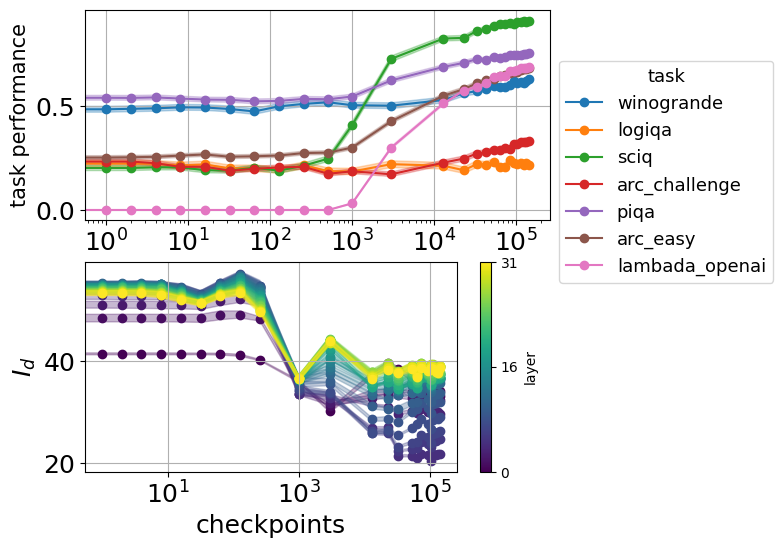

In [122]:
models = ['6.9b', '1.4b', '410m']
fig, axs = plt.subplots(2,1, figsize=(6,6))
model = '6.9b'
layers = np.arange(31)
taskperf_result = pd.read_csv('task_performance_summary.csv')

ax = axs[0]
TASKS = [t for t in taskperf_result['task'].unique() if "hendrycks" not in t and "crows" not in t and t != 'wsc' ]
for i,t in enumerate(TASKS):
    task_cond = (taskperf_result['task'] == t) & (taskperf_result['model_size']==model) & (taskperf_result['shot'] == 0)

    steps=taskperf_result[task_cond]['step']
    accs=taskperf_result[task_cond]['acc']
    stds=taskperf_result[task_cond]['acc_stderr']
    sort_steps_inds = np.argsort(steps.values)
    sorted_steps = steps.iloc[sort_steps_inds]
    sorted_accs = accs.iloc[sort_steps_inds]
    sorted_stds = stds.iloc[sort_steps_inds]

    ax.plot(sorted_steps, sorted_accs, marker = 'o', label = t, c = f'C{i}')
    ax.fill_between(sorted_steps,
                sorted_accs - sorted_stds,
                sorted_accs + sorted_stds,
                alpha=0.3,
                color = f'C{i}')
    ax.set_xscale('log')
#ax.set_xlabel('checkpoints', fontsize= 18)
ax.set_ylabel('task performance', fontsize = 15)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(True)
ax.legend(title = 'task', bbox_to_anchor = [1,0.8], fontsize=13, title_fontsize=13)


ax = axs[1]
import matplotlib
colormap = plt.cm.viridis  #or any other colormap
normalize = matplotlib.colors.Normalize(vmin=0, vmax=len(layers)-1)

#fig, axs = plt.subplots(2,1, figsize=(6,6),)
steps = np.sort(taskperf_result['step'].unique())
ax.grid(True)
twonn_mean_list=np.empty((len(layers), len(steps)))
pca_mean_list=np.empty((len(layers), len(steps)))

twonn_std_list=np.empty((len(layers), len(steps)))
pca_std_list=np.empty((len(layers), len(steps)))

for i, layer in enumerate(layers):
    for j, s in enumerate(steps):
        id_cond = (results_df['words_coupled'] == 1) & (results_df['mode'] == "sane") & (results_df['layer'] == layer) & (results_df['model'] == model) & (results_df['step'] ==s)
        twonn_mean = results_df[id_cond]['twonn_mean']
        twonn_std = results_df[id_cond]['twonn_std']
        pca_mean= results_df[id_cond]['pca_mean']
        pca_std= results_df[id_cond]['pca_std']
        if len(twonn_mean) ==1:
            twonn_mean_list[i,j] = twonn_mean.item()
            twonn_std_list[i,j] = twonn_std.item()
        else:
            twonn_mean_list[i,j] = np.nan
            twonn_std_list[i,j] = np.nan
        
        if len(pca_mean) ==1:
            pca_mean_list[i,j] = pca_mean.item()
            pca_std_list[i,j] = pca_std.item()
        else:
            pca_mean_list[i,j] = np.nan
            pca_std_list[i,j] = np.nan

for i in range(len(layers)):
    a = ax.scatter(steps[~np.isnan(twonn_mean_list[i])], twonn_mean_list[i,~np.isnan(twonn_mean_list[i])], marker = 'o', color=colormap(normalize(i)))
    ax.fill_between(steps[~np.isnan(twonn_mean_list[i])], 
                twonn_mean_list[i,~np.isnan(twonn_mean_list[i])] - twonn_std_list[i,~np.isnan(twonn_std_list[i])],
                twonn_mean_list[i,~np.isnan(twonn_mean_list[i])] + twonn_std_list[i,~np.isnan(twonn_std_list[i])],
                alpha=0.3,
                color = colormap(normalize(i)))
    #ax.plot(steps[~np.isnan(pca_list[i])], pca_list[i,~np.isnan(pca_list[i])], marker = '^', ls = '--', c = f'C{i}' )
ax.set_xscale('log')
ax.set_xlabel('checkpoints', fontsize= 18)
ax.set_ylabel(r'$I_{d}$', fontsize = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cbar=fig.colorbar(a, ax = ax, label = 'layer', )
cbar.ax.set_yticklabels(['0','16','31'])
cbar.ax.set_yticks([0,0.5,1])


#fig, ax = plt.subplots(1,1, figsize=(6,3),)
steps = np.sort(taskperf_result['step'].unique())
ax.grid(True)

"""
for i in range(len(layers)):
    ax.scatter(steps[~np.isnan(pca_mean_list[i])], pca_mean_list[i,~np.isnan(pca_mean_list[i])], marker = 'o', color=colormap(normalize(i)))
    ax.fill_between(steps[~np.isnan(pca_mean_list[i])], 
                pca_mean_list[i,~np.isnan(pca_mean_list[i])] - pca_std_list[i,~np.isnan(pca_std_list[i])],
                pca_mean_list[i,~np.isnan(pca_mean_list[i])] + pca_std_list[i,~np.isnan(pca_std_list[i])],
                alpha=0.3,
                 color=colormap(normalize(i)))
ax.set_xscale('log')
ax.set_xlabel('checkpoints', fontsize= 18)
ax.set_ylabel(r'$d$', fontsize = 18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
plt.legend(title = 'layer', bbox_to_anchor = [1,0.8], fontsize=13, title_fontsize=13)
"""


In [54]:
twonn_list

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan]])

In [53]:
pca

Series([], Name: pca_mean, dtype: float64)

In [50]:
print(steps)

[     0      1      2      4      8     16     32     64    128    256
    512   1000   3000  13000  23000  33000  43000  53000  63000  73000
  83000  93000 103000 113000 123000 133000 143000]


In [52]:
np.isnan(twonn_list[i])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])